# Exploration of PFAM domains and HMM profiles from EC number
Functional Enzyme Discovery, Validation, and Integration from Metagenomic Data 

**From known reactions (EC numbers)**  it collect reference enzymes from curated sources (UniProt, Swissprot).


In [2]:
import os
from pathlib import Path

# Specify the EC number of interest ! -- EDIT THIS VALUE AS NEEDED --

EC = "3.1.1.3"

##### PATH SETTINGS #####


PROJECT_ROOT = Path.cwd().parents[0]   # go up from notebooks/ to project/

DATA_DIR     = PROJECT_ROOT / "data" / "reference_data"
PFAM_A_DIR   = PROJECT_ROOT / "data" / "pfam_db"
SCRIPTS_PATH = PROJECT_ROOT / "src"  / "ec_pfam_hmm"




# Derived paths
EC_PATH = DATA_DIR / f"EC{EC}"  # e.g., files/clean_pipeline/EC3.1.1.74
PFAM_HMMS = EC_PATH / "pfam_hmms"

# Export to environment (bash cells will see these)
os.environ["DATA_DIR"] = str(DATA_DIR)
os.environ["PFAM_A_DIR"] = str(PFAM_A_DIR)
os.environ["EC"] = EC
os.environ["scripts_path"] = str(SCRIPTS_PATH)
os.environ["ec_path"] = str(EC_PATH)
os.environ["pfam_hmms"] = str(PFAM_HMMS)


# (Optional) also keep mirrored Python variables around explicitly
DATA_DIR_STR = os.environ["DATA_DIR"]
PFAM_A_DIR_STR = os.environ["PFAM_A_DIR"]
EC_STR = os.environ["EC"]
SCRIPTS_PATH_STR = os.environ["scripts_path"]
EC_PATH_STR = os.environ["ec_path"]

# Quick sanity print (comment out if noisy)
print("DATA_DIR      =", DATA_DIR_STR)
print("PFAM_A_DIR    =", PFAM_A_DIR_STR)
print("EC            =", EC_STR)
print("scripts_path  =", SCRIPTS_PATH_STR)
print("ec_path    =", EC_PATH_STR)
print("pfam_hmms    =", PFAM_HMMS)



DATA_DIR      = /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data
PFAM_A_DIR    = /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/pfam_db
EC            = 3.1.1.3
scripts_path  = /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/src/ec_pfam_hmm
ec_path    = /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3
pfam_hmms    = /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3/pfam_hmms


## 1) Reference selection (EC → reference enzymes) 

- Select EC numbers of interest (e.g., **3.1.1.74** cutinase, others for polyester/polysaccharide hydrolases).
- Retrieve **reference sequences** (UniProt reviewed), and **mechanistic fingerprints** (catalytic residues) from **M-CSA**.
- Save to `data-path/ref/refs.fa` and a small `refs_meta.tsv` with EC, Pfam, catalytic motif notes.

### Download Pfam HMMs - In case of not having it already downloaded

In [3]:
%%bash

ls -ltr $scripts_path


total 32
-rwxr-xr-x 1 mora.toneguzzo staff  5218 Nov 28 15:52 1_enrich_uniprot.py
-rwxr-xr-x 1 mora.toneguzzo staff  7144 Nov 28 15:52 uniprot_entries_vis.py
-rwxr-xr-x 1 mora.toneguzzo staff 10741 Nov 28 15:52 2_score_references.py
-rwxr-xr-x 1 mora.toneguzzo staff  3900 Nov 28 15:52 3_HMM_FASTA_files.sh


In [ ]:
%%bash
#Download the HMM profiles once

# 1) Get the combined Pfam HMMs (large ~2–3 GB)
#curl -L https://ftp.ebi.ac.uk/pub/databases/Pfam/current_release/Pfam-A.hmm.gz -o ${PFAM_A_DIR_STR}/Pfam-A.hmm.gz

# 2) Decompress and index
#gunzip -f ${EC}

### EC -> Uniprot entries

This block automates the retrieval of **reviewed UniProt (Swiss-Prot) entries** for a specified **Enzyme Commission (EC)** number.

**What it does:**

1. **Creates directories**  
   - Sets up a base working folder (`$DATA_DIR`) and a subfolder for the specific EC (e.g., `EC3.1.1.74`).

2. **Downloads reviewed protein sequences**  
   - Uses the UniProt REST API to fetch all *reviewed=true* entries matching the EC number in **FASTA format**.

3. **Downloads metadata**  
   - Retrieves a **TSV table** with selected fields (accession, gene name, organism, Pfam, InterPro, PDB, GO terms, etc.).

4. **Shows available helper scripts**  
   - Lists contents of the `$scripts_path` directory to confirm auxiliary tools are present.

5. **Optional post-processing**  
   - Runs the Python helper script `uniprot_entries_vis.py` (if available) to visualize or process the UniProt data further, such as building HMMs or summaries.

**Output files:**
- `EC<EC>.reviewed.fa` — FASTA sequences  
- `EC<EC>.reviewed.tsv` — metadata table  
Stored under:  
`$DATA_DIR/EC<EC>/`

**In short:**  
This script automatically gathers curated UniProt reference sequences and annotations for a given EC number and prepares them for downstream bioinformatics analyses.



Runs `uniprot_entries_vis.py`:
-    Summarize reviewed UniProtKB entries for a given EC number from a pre-fetched TSV,
-    generate quick visuals (PFAM distribution, top organisms, length histogram),
-    and write a compact JSON summary. (Optional Pfam-HMM download block is present but commented.)

`




In [4]:
%%bash

output_path=$DATA_DIR/
mkdir -p $output_path

cd $output_path # <--- change to working directory of all the files 
set -euo pipefail

OUTDIR="EC${EC}"
mkdir -p "${OUTDIR}"

echo "[info] Fetching reviewed UniProt entries for EC=${EC}..."

# FASTA (reviewed only)
curl -sL "https://rest.uniprot.org/uniprotkb/search?query=ec:${EC}%20AND%20reviewed:true&format=fasta" \
  -o "${OUTDIR}/EC${EC}.reviewed.fa"

# TSV metadata (add/remove fields as you like)
FIELDS="accession,id,protein_name,gene_primary,organism_name,organism_id,length,ec,xref_pfam,xref_interpro,xref_pdb,go_f,go_p"
curl -sL "https://rest.uniprot.org/uniprotkb/search?query=ec:${EC}%20AND%20reviewed:true&format=tsv&fields=${FIELDS}" \
  -o "${OUTDIR}/EC${EC}.reviewed.tsv"

echo "[done] Saved to ${OUTDIR}/"


ls "${scripts_path}"


python "${scripts_path}"/uniprot_entries_vis.py --ec "${EC}" --workdir . --download-hmms

[info] Fetching reviewed UniProt entries for EC=3.1.1.3...
[done] Saved to EC3.1.1.3/
1_enrich_uniprot.py
2_score_references.py
3_HMM_FASTA_files.sh
uniprot_entries_vis.py
[info] EC=3.1.1.3
[info] Sequences: 25
[info] Columns: ['Entry', 'Entry Name', 'Protein names', 'Gene Names (primary)', 'Organism', 'Organism (ID)', 'Length', 'EC number', 'Pfam', 'InterPro', 'PDB', 'Gene Ontology (molecular function)', 'Gene Ontology (biological process)', 'Pfam_list']
[save] /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3/EC3.1.1.3.pfam_top.png
[save] /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3/EC3.1.1.3.length_hist.png
[save] /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNe

Runs `1_enrich_uniprot.py`:

Output:
- A TSV with all original columns plus three new columns:
     - reviewed     : "reviewed" | "unreviewed" (derived from entryType)
    - xref_cazy    : semicolon-separated CAZy families/IDs (deduplicated, order-preserving)
    - xref_esther  : semicolon-separated ESTHER families/IDs (deduplicated, order-preserving)


In [5]:
%%bash

TSV="${DATA_DIR}"/EC"${EC}"/EC"${EC}".enriched.tsv
python "${scripts_path}"/1_enrich_uniprot.py "${DATA_DIR}"/EC"${EC}"/EC"${EC}".reviewed.tsv "${TSV}"

cat "${TSV}"

echo "Number of rows in TSV:"
tail -n +2 "${TSV}" | wc -l



# echo $TARGET_EC

# python "${scripts_path}"/2_score_references.py "$TSV" \
#   --target_ecs 3.1.1.74 \
#   --write-full "${DATA_DIR}"/EC"${EC}"/EC"${EC}".polyester_hits.tsv



acc	entry	protein	gene	organism	taxid	length	ec_list	pfam_list	interpro_list	pdb_list	go_mf	go_bp	reviewed	xref_cazy	xref_esther
P07098	LIPF_HUMAN	Gastric triacylglycerol lipase (GL) (Gastric lipase) (EC 3.1.1.3)	LIPF	Homo sapiens (Human)	9606	398	3.1.1.3	PF00561;	IPR000073;IPR029058;IPR025483;	1HLG;	lipid binding [GO:0008289]; malate dehydrogenase activity [GO:0016615]; triacylglycerol lipase activity [GO:0004806]	lipid catabolic process [GO:0016042]; malate metabolic process [GO:0006108]; triglyceride metabolic process [GO:0006641]	reviewed		Acidic_Lipase
P41247	PLPL4_HUMAN	Patatin-like phospholipase domain-containing protein 4 (EC 3.1.1.3) (Calcium-independent phospholipase A2-eta) (iPLA2-eta) (EC 3.1.1.4) (Protein GS2)	PNPLA4	Homo sapiens (Human)	9606	253	3.1.1.3; 3.1.1.4	PF01734;	IPR016035;IPR033562;IPR033902;IPR002641;		acylglycerol O-acyltransferase activity [GO:0016411]; all-trans-retinyl-palmitate hydrolase, all-trans-retinol forming activity [GO:0047376]; diolein transacylati

### Enriched TSV → Compact export + PFAM analysis

**Purpose:**  
Load an enriched UniProt TSV for a given EC, export a compact table, and summarize PFAM usage (overall and by EC).

**What it does:**
1. **Setup:** Reads `DATA_DIR`, `EC` (defaults provided). Builds:
   - Input: `<DATA_DIR>/EC<EC>/EC<EC>.enriched.tsv`
   - Output prefix: `<DATA_DIR>/EC<EC>/all_hits*`
2. **Load & sort:** Reads TSV with pandas; sorts by `organism`, `acc` when present.
3. **Compact export:** Keeps selected columns  
   `acc, entry, organism, length, ec_list, pfam_list, pdb_list, reviewed, xref_cazy, xref_esther, MatchedBy`  
   → writes `all_hits_compact.tsv`.
4. **PFAM overall counts:** Parses/separates `pfam_list`, normalizes to `PFxxxxx`, counts occurrences.  
   → writes `all_hits_pfam_overall_counts.tsv` and (if possible) shows a bar plot of top `TOP_N_PFAMS`.
5. **PFAM by EC:** Explodes `ec_list` and `pfam_list`, merges per-row, groups by `(EC, PFAM)`.  
   → writes `all_hits_pfam_by_ec_long.tsv` and a pivot matrix `all_hits_pfam_by_ec_pivot.tsv`.

**Notes:**  
- Robust to missing columns (skips steps accordingly).  
- PFAM/EC fields may be semicolon/comma/space-separated; script normalizes before counting.

Using INPUT_TSV: /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3/EC3.1.1.3.enriched.tsv
✔ Wrote /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3/all_hits_compact.tsv (25 rows)
✔ Wrote PFAM overall counts: /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3/all_hits_pfam_overall_counts.tsv


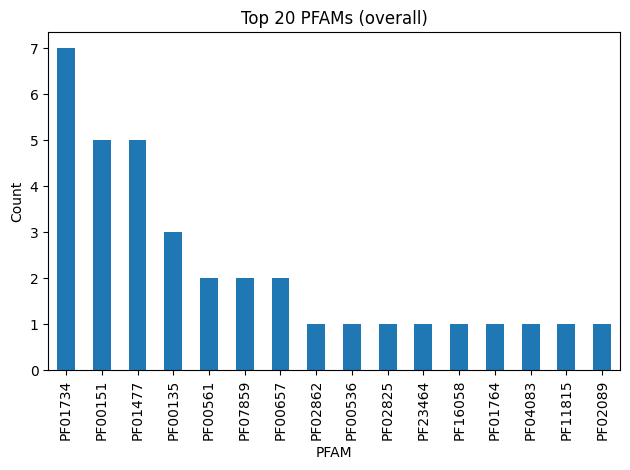

✔ Wrote PFAM counts by EC (long): /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3/all_hits_pfam_by_ec_long.tsv


In [6]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------- PARAMETERS ---------------------------------------
DATA_DIR = os.environ.get("DATA_DIR", "files/clean_pipeline")
EC       = os.environ.get("EC", "3.1.1.74")
TOP_N_PFAMS = 20
SORT_BY = ["organism","acc"]
# -----------------------------------------------------------------------------

# Build paths
INPUT_TSV     = Path(DATA_DIR) / f"EC{EC}" / f"EC{EC}.enriched.tsv"
OUTPUT_PREFIX = Path(DATA_DIR) / f"EC{EC}" / "all_hits"

print("Using INPUT_TSV:", INPUT_TSV)

df = pd.read_csv(INPUT_TSV, sep="\t")

# Sort safely
sort_by = [c for c in SORT_BY if c in df.columns]
if sort_by:
    df = df.sort_values(sort_by)

# Ensure output folder exists
OUTPUT_PREFIX.parent.mkdir(parents=True, exist_ok=True)

# --------------------------- COMPACT EXPORT -----------------------------------
wanted = ["acc","entry","organism","length","ec_list","pfam_list",
          "pdb_list","reviewed","xref_cazy","xref_esther","MatchedBy"]
keep = [c for c in wanted if c in df.columns]
out_compact = OUTPUT_PREFIX.with_name(OUTPUT_PREFIX.name + "_compact.tsv")
df[keep].to_csv(out_compact, sep="\t", index=False)
print(f"✔ Wrote {out_compact} ({len(df)} rows)")

# --------------------------- PFAM ANALYSIS ------------------------------------
def _split_semilist(series):
    s = (series.fillna("")
               .str.replace(r"[;\s]+$", "", regex=True)
               .str.split(r"[;,\s]+"))
    return s.explode().replace("", np.nan).dropna()

def _normalize_pfam(series):
    out = series.astype(str).str.upper().str.strip()
    out = out.str.replace(r"[^A-Z0-9]", "", regex=True)
    return out[out.str.match(r"^PF\d+$", na=False)]

def _split_ec(series):
    s = (series.fillna("")
               .str.replace(r"[;\s]+$", "", regex=True)
               .str.split(r"[;,\s]+"))
    ec = s.explode().replace("", np.nan).dropna()
    return ec.str.strip()

pf_counts = None

# ---- Overall PFAM counts + optional bar plot
if "pfam_list" in df.columns:
    pf_series_all = _normalize_pfam(_split_semilist(df["pfam_list"]))
    if not pf_series_all.empty:
        pf_counts = pf_series_all.value_counts()
        # write overall counts
        out_overall_counts = OUTPUT_PREFIX.with_name(OUTPUT_PREFIX.name + "_pfam_overall_counts.tsv")
        pf_counts.to_csv(out_overall_counts, sep="\t", header=["count"])
        print(f"✔ Wrote PFAM overall counts: {out_overall_counts}")
        # bar plot (optional)
        try:
            ax = pf_counts.head(TOP_N_PFAMS).plot(kind="bar",
                                                  title=f"Top {TOP_N_PFAMS} PFAMs (overall)")
            ax.set_xlabel("PFAM"); ax.set_ylabel("Count")
            plt.tight_layout(); plt.show()
        except Exception as e:
            print("(Skipping PFAM bar plot)", e)
    else:
        print("No PFAMs found after normalization; skipping overall PFAM counts.")
else:
    print("pfam_list column not found; skipping PFAM analysis entirely.")

# ---- PFAM counts by EC (long + pivot), only if we have both ECs and PFAMs
if ("ec_list" in df.columns) and ("pfam_list" in df.columns):
    ec_series = _split_ec(df["ec_list"]).rename("EC")
    pf_series = _normalize_pfam(_split_semilist(df["pfam_list"])).rename("PFAM")
    # attach row ids for merge
    ec_long = ec_series.reset_index().rename(columns={"index": "row_id"})
    pf_long = pf_series.reset_index().rename(columns={"index": "row_id"})
    if not ec_long.empty and not pf_long.empty:
        ec_pfam = ec_long.merge(pf_long, on="row_id", how="inner")
        if not ec_pfam.empty:
            ec_pfam_counts = (ec_pfam.groupby(["EC","PFAM"])
                                      .size().reset_index(name="count")
                                      .sort_values(["EC","count"], ascending=[True, False]))
            out_by_ec_long = OUTPUT_PREFIX.with_name(OUTPUT_PREFIX.name + "_pfam_by_ec_long.tsv")
            ec_pfam_counts.to_csv(out_by_ec_long, sep="\t", index=False)
            print(f"✔ Wrote PFAM counts by EC (long): {out_by_ec_long}")

            pivot = (ec_pfam_counts.pivot(index="PFAM", columns="EC", values="count")
                                   .fillna(0).astype(int).sort_index())
            out_by_ec_pivot = OUTPUT_PREFIX.with_name(OUTPUT_PREFIX.name + "_pfam_by_ec_pivot.tsv")
            #pivot.to_csv(out_by_ec_pivot, sep="\t")
            #print(f"✔ Wrote PFAM × EC matrix: {out_by_ec_pivot} (shape {pivot.shape})")
        else:
            print("No EC–PFAM combinations after merge; skipping by-EC summaries.")
    else:
        print("Empty EC or PFAM lists; skipping by-EC summaries.")

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------- PARAMETERS ---------------------------------------
DATA_DIR = os.environ.get("DATA_DIR", "files/clean_pipeline")
EC       = os.environ.get("EC", "3.1.1.74")
TOP_N_PFAMS = 20
# -----------------------------------------------------------------------------

# Build paths
EC_DIR      = Path(DATA_DIR) / f"EC{EC}"
INPUT_TSV   = EC_DIR / f"EC{EC}.enriched.tsv"
PFAM_COUNTS = EC_DIR / f"EC{EC}.pfam_overall_counts.tsv"

print("Using INPUT_TSV:", INPUT_TSV)

# Ensure directory exists (usually ya existe, pero por si acaso)
EC_DIR.mkdir(parents=True, exist_ok=True)

# Load table
df = pd.read_csv(INPUT_TSV, sep="\t")

# --------------------------- PFAM ANALYSIS ------------------------------------

def _split_semilist(series: pd.Series) -> pd.Series:
    """Split semi-colon / comma separated lists into one value per row."""
    s = (
        series.fillna("")
              .str.replace(r"[;\s]+$", "", regex=True)
              .str.split(r"[;,\s]+")
    )
    return s.explode().replace("", np.nan).dropna()

def _normalize_pfam(series: pd.Series) -> pd.Series:
    """Uppercase, strip and keep only PFxxxxx style IDs."""
    out = series.astype(str).str.upper().str.strip()
    out = out.str.replace(r"[^A-Z0-9]", "", regex=True)
    return out[out.str.match(r"^PF\d+$", na=False)]

if "pfam_list" not in df.columns:
    print("pfam_list column not found; skipping PFAM analysis.")
else:
    pf_series_all = _normalize_pfam(_split_semilist(df["pfam_list"]))

    if pf_series_all.empty:
        print("No PFAMs found after normalization; nothing to do.")
    else:
        # Conteos globales
        pf_counts = pf_series_all.value_counts()

        # Guardar ÚNICO fichero de salida necesario para inspección
        pf_counts.to_csv(PFAM_COUNTS, sep="\t", header=["count"])
        print(f"✔ Wrote PFAM overall counts: {PFAM_COUNTS}")

        # Plot Top N PFAM
        try:
            ax = pf_counts.head(TOP_N_PFAMS).plot(
                kind="bar",
                title=f"Top {TOP_N_PFAMS} PFAMs for EC {EC}"
            )
            ax.set_xlabel("PFAM")
            ax.set_ylabel("Count")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("(Skipping PFAM bar plot)", e)

## 2)Download Files


Runs `3_HMM_FASTA_files.min.sh`:

**Purpose:**  
Extracts the specific **PFAM HMM profiles** referenced in a UniProt TSV file and builds:
- Individual per-PFAM HMM files  
- A single concatenated subset HMM file

### Inputs
- **TSV** – Enriched UniProt file (e.g. `EC3.1.1.74.enriched.tsv`) containing a `pfam_list` column  
- **OUTPREFIX** – Output prefix (e.g. `/path/EC3.1.1.74/EC3.1.1.74`)  
- **PFAM_DB** – Pfam database (`Pfam-A.hmm`)


### Outputs
- **Per-PFAM HMM files** - `<output_dir>/pfam_hmms/<PFxxxxx.version>.hm`
- **Concatenated subset HMM file**  - `<OUTPREFIX>.Pfam-A.subset.hmm`
- No FASTA or `hmmpress` side files are created.


### Workflow Summary
1. Detects the PFAM column in the TSV (`pfam_list`, `Pfam`, etc.)
2. Extracts and cleans PFAM accessions (e.g. `PF01083`)
3. Finds the **latest version** of each PFAM in the `Pfam-A.hmm` database
4. Uses `hmmfetch` to extract those profiles
5. Saves:
 - Individual files under `pfam_hmms/`
 - Combined file as `<OUTPREFIX>.Pfam-A.subset.hmm`
6. Logs progress and warnings if some profiles are missing


In [13]:
%%bash
set -u pipefail

bash -x "${scripts_path}/3_HMM_FASTA_files.sh" \
  "${DATA_DIR}/EC${EC}/EC${EC}.enriched.tsv" \
  "${DATA_DIR}/EC${EC}/EC${EC}" \
  "${PFAM_A_DIR}/Pfam-A.hmm"

+ set -u
+ export PATH=/opt/homebrew/bin:/Users/mora.toneguzzo/miniconda/envs/homl3/bin:/Users/mora.toneguzzo/.local/bin:/opt/homebrew/Cellar/openjdk@21/21.0.8/libexec/openjdk.jdk/Contents/Home/bin:/Users/mora.toneguzzo/.nvm/versions/node/v20.17.0/bin:/Users/mora.toneguzzo/miniconda/envs/homl3/bin:/Users/mora.toneguzzo/miniconda/condabin:/opt/homebrew/opt/coreutils/libexec/gnubin:/opt/homebrew/bin:/Library/Frameworks/Python.framework/Versions/3.12/bin:/opt/local/bin:/opt/local/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/X11/bin:/Library/TeX/texbin
+ PATH=/opt/homebrew/bin:/Users/mora.toneguzzo/miniconda/envs/homl3/bin:/Users/mora.toneguzzo/.local/bin:/opt/homebrew/Cellar/openjdk@21/21.0.8/libexec/openjdk.jdk/Contents/Home/bin

/opt/homebrew/bin/hmmfetch


+ which hmmpress


/opt/homebrew/bin/hmmpress


+ TSV=/Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3/EC3.1.1.3.enriched.tsv
+ OUTPREFIX=/Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3/EC3.1.1.3
+ PFAM_DB=/Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/pfam_db/Pfam-A.hmm
++ dirname /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3/EC3.1.1.3
+ OUTDIR=/Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/data/reference_data/EC3.1.1.3
++ basename /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformati